In [1]:
import pickle
import os
import numpy as np  
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, classification_report, roc_curve
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from collections import defaultdict

In [2]:
# df_churn = pd.read_csv('data/churn/Telco-Customer-Churn.csv')
# df_churn = df_churn.drop(['customerID'], axis=1)
# product_ids = np.arange(1, 100+1)
# product_id_array = np.random.choice(product_ids, df_churn.shape[0], replace=True)
# df_churn["ProdID"] = product_id_array
# df_churn.to_csv('data/churn/Telco-Customer-Churn-ProdID.csv', index=False)

In [3]:
df_churn = pd.read_csv('data/churn/Telco-Customer-Churn.csv')
df_churn = df_churn.drop(['customerID'], axis=1)
df_churn

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [4]:
# Check null values 
df_churn.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [5]:
def dictioanry_label_encoding(
                            df, 
                            categorical_features,
                            encoder_path = 'weights/churn/label_encoder.pickle'
                            ):
    """
    Encode categorical features in the DataFrame using label encoding.

    Args:
        df (DataFrame): The DataFrame containing the data to be encoded.
        categorical_features (list): List of column names corresponding to categorical features.
        encoder_path (str, optional): Path to save the label encoder. Defaults to 'weights/churn/label_encoder.pickle'.

    Returns:
        DataFrame: DataFrame with categorical features encoded.
    """
    # Check if encoder file exists
    if not os.path.exists(encoder_path):
        # If not, create a new label encoder dictionary
        label_encoder = defaultdict()
        # Iterate over each categorical feature
        for col in categorical_features:
            # Create label encoder mapping unique values to integer labels
            label_encoder[col] = {k: v for v, k in enumerate(df[col].unique())}
            # Map the labels to the corresponding column in the DataFrame
            df[col] = df[col].map(label_encoder[col])
        # Save the label encoder dictionary to a pickle file
        with open(encoder_path, 'wb') as f:
            pickle.dump(label_encoder, f)
    else:
        # If encoder file exists, load the label encoder dictionary
        with open(encoder_path, 'rb') as f:
            label_encoder = pickle.load(f)
            # Map the labels to the corresponding column in the DataFrame
            for col in categorical_features:
                df[col] = df[col].map(label_encoder[col])

    return df

def preprocess_churn_data(
                        categorical_features = [
                                                'gender',
                                                'Partner',
                                                'Dependents',
                                                'PhoneService',
                                                'MultipleLines',
                                                'InternetService',
                                                'OnlineSecurity',
                                                'OnlineBackup',
                                                'DeviceProtection',
                                                'TechSupport',
                                                'StreamingTV',
                                                'StreamingMovies',
                                                'Contract',
                                                'PaperlessBilling',
                                                'PaymentMethod'
                                                ]
                        ):
    """
    Preprocess churn data by encoding categorical features and converting labels to float.

    Args:
        categorical_features (list): List of column names corresponding to categorical features.

    Returns:
        DataFrame: Preprocessed DataFrame ready for churn analysis.
    """
    # Read churn data from CSV file
    df_churn = pd.read_csv('data/churn/Telco-Customer-Churn.csv')
    # Drop unnecessary column 'customerID'
    df_churn = df_churn.drop(['customerID'], axis=1)
    # Replace empty spaces with NaN and drop rows with missing values
    df_churn = df_churn.replace(' ', np.nan).dropna()
    # Encode categorical features using label encoding
    df_churn = dictioanry_label_encoding(df_churn, categorical_features)
    # Map 'Churn' column to binary labels (0 or 1)
    df_churn['Churn'] = df_churn['Churn'].map({'Yes': 1, 'No': 0})
    # Convert DataFrame to float type
    df_churn = df_churn.astype('float')
    return df_churn


In [6]:
# Preprocess churn data and display
df_churn = preprocess_churn_data()
df_churn

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.85,29.85,0.0
1,1.0,0.0,1.0,0.0,34.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,56.95,1889.50,0.0
2,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,53.85,108.15,1.0
3,1.0,0.0,1.0,0.0,45.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,42.30,1840.75,0.0
4,0.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.70,151.65,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.0,0.0,0.0,1.0,24.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,84.80,1990.50,0.0
7039,0.0,0.0,0.0,1.0,72.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,103.20,7362.90,0.0
7040,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.60,346.45,0.0
7041,1.0,1.0,0.0,0.0,4.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,74.40,306.60,1.0


In [7]:
# Split the dataset into features (X) and target variable (Y)
X = df_churn.drop(['Churn'], axis=1)  
Y = df_churn['Churn']  

In [8]:
# Split Data into Train and Test Sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Cross-Validation
def evaluate_model(model, X_train, Y_train):
    scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='accuracy')
    return scores.mean()

# Hyperparameter Tuning
def tune_model(model, param_grid, X_train, Y_train):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, Y_train)
    return grid_search.best_estimator_

# Feature Scaling/Normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Evaluation Metrics
def evaluate_metrics(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred)
    return accuracy, precision, recall, f1, roc_auc

# Model Selection 
models = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(),
    "XGBoost": XGBClassifier(),
    "FFNN": MLPClassifier(max_iter=1000), 
    "Voting Classifier": VotingClassifier(
        estimators=[
            ('rf', RandomForestClassifier()),
            ('svm', SVC()),
            ('lr', LogisticRegression()),
            ('xgb', XGBClassifier()),
            ('ffnn', MLPClassifier(max_iter=1000))  
        ]
    )
}

best_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    
    # Evaluate model using cross-validation
    cv_score = evaluate_model(model, X_train_scaled, Y_train)
    print(f"Cross-Validation Accuracy for {name}: {cv_score}")
    
    # Tune hyperparameters
    if name == "SVM":
        param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}
    elif name == "Random Forest":
        param_grid = {'n_estimators': [100, 200, 300]}
    elif name == "XGBoost":
        param_grid = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.3]}
    elif name == "Logistic Regression":
        param_grid = {'C': [0.1, 1, 10]}
    elif name == "FFNN":
        param_grid = {'hidden_layer_sizes': [(50,), (100,), (50, 50)]}
    elif name == "Voting Classifier":
        param_grid = {}
    else:
        param_grid = {}
    
    if param_grid:
        best_model = tune_model(model, param_grid, X_train_scaled, Y_train)
        best_models[name] = best_model
        print(f"Best parameters for {name}: {best_model.get_params()}")
    
    # Evaluate metrics
    if name in best_models:
        best_model = best_models[name]
    else:
        best_model = model
    
    best_model.fit(X_train_scaled, Y_train)
    accuracy, precision, recall, f1, roc_auc = evaluate_metrics(best_model, X_test_scaled, Y_test)
    print(f"Test Set Metrics for {name}:")
    print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}, ROC AUC: {roc_auc}")
    print("\n")

Training Random Forest...
Cross-Validation Accuracy for Random Forest: 0.7992888888888888
Best parameters for Random Forest: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Test Set Metrics for Random Forest:
Accuracy: 0.7896233120113717, Precision: 0.6363636363636364, Recall: 0.48663101604278075, F1-Score: 0.5515151515151515, ROC AUC: 0.6929766890475278


Training SVM...
Cross-Validation Accuracy for SVM: 0.8014222222222223
Best parameters for SVM: {'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1,

In [9]:
# Make predictions for each best model on the test set
predictions = {}

# Iterate through the best models and make predictions
for name, model in best_models.items():
    # Make predictions using each model and store them in the predictions dictionary
    print(f"Making predictions using {name}...")
    if name == "Random Forest":
        Prfc = model.predict(X_test_scaled)
        predictions[name] = Prfc
    elif name == "XGBoost":
        Pxgb = model.predict(X_test_scaled)
        predictions[name] = Pxgb
    elif name == "SVM":
        Psvc = model.predict(X_test_scaled)
        predictions[name] = Psvc
    elif name == "Logistic Regression":
        Plr = model.predict(X_test_scaled)
        predictions[name] = Plr
    elif name == "FFNN":
        Pffnn = model.predict(X_test_scaled)
        predictions[name] = Pffnn

# Make predictions using the voting classifier outside the loop
print("Making predictions using Voting Classifier...")
Pvoting = models["Voting Classifier"].predict(X_test_scaled)
predictions["Voting Classifier"] = Pvoting


Making predictions using Random Forest...
Making predictions using SVM...
Making predictions using Logistic Regression...
Making predictions using XGBoost...
Making predictions using FFNN...
Making predictions using Voting Classifier...


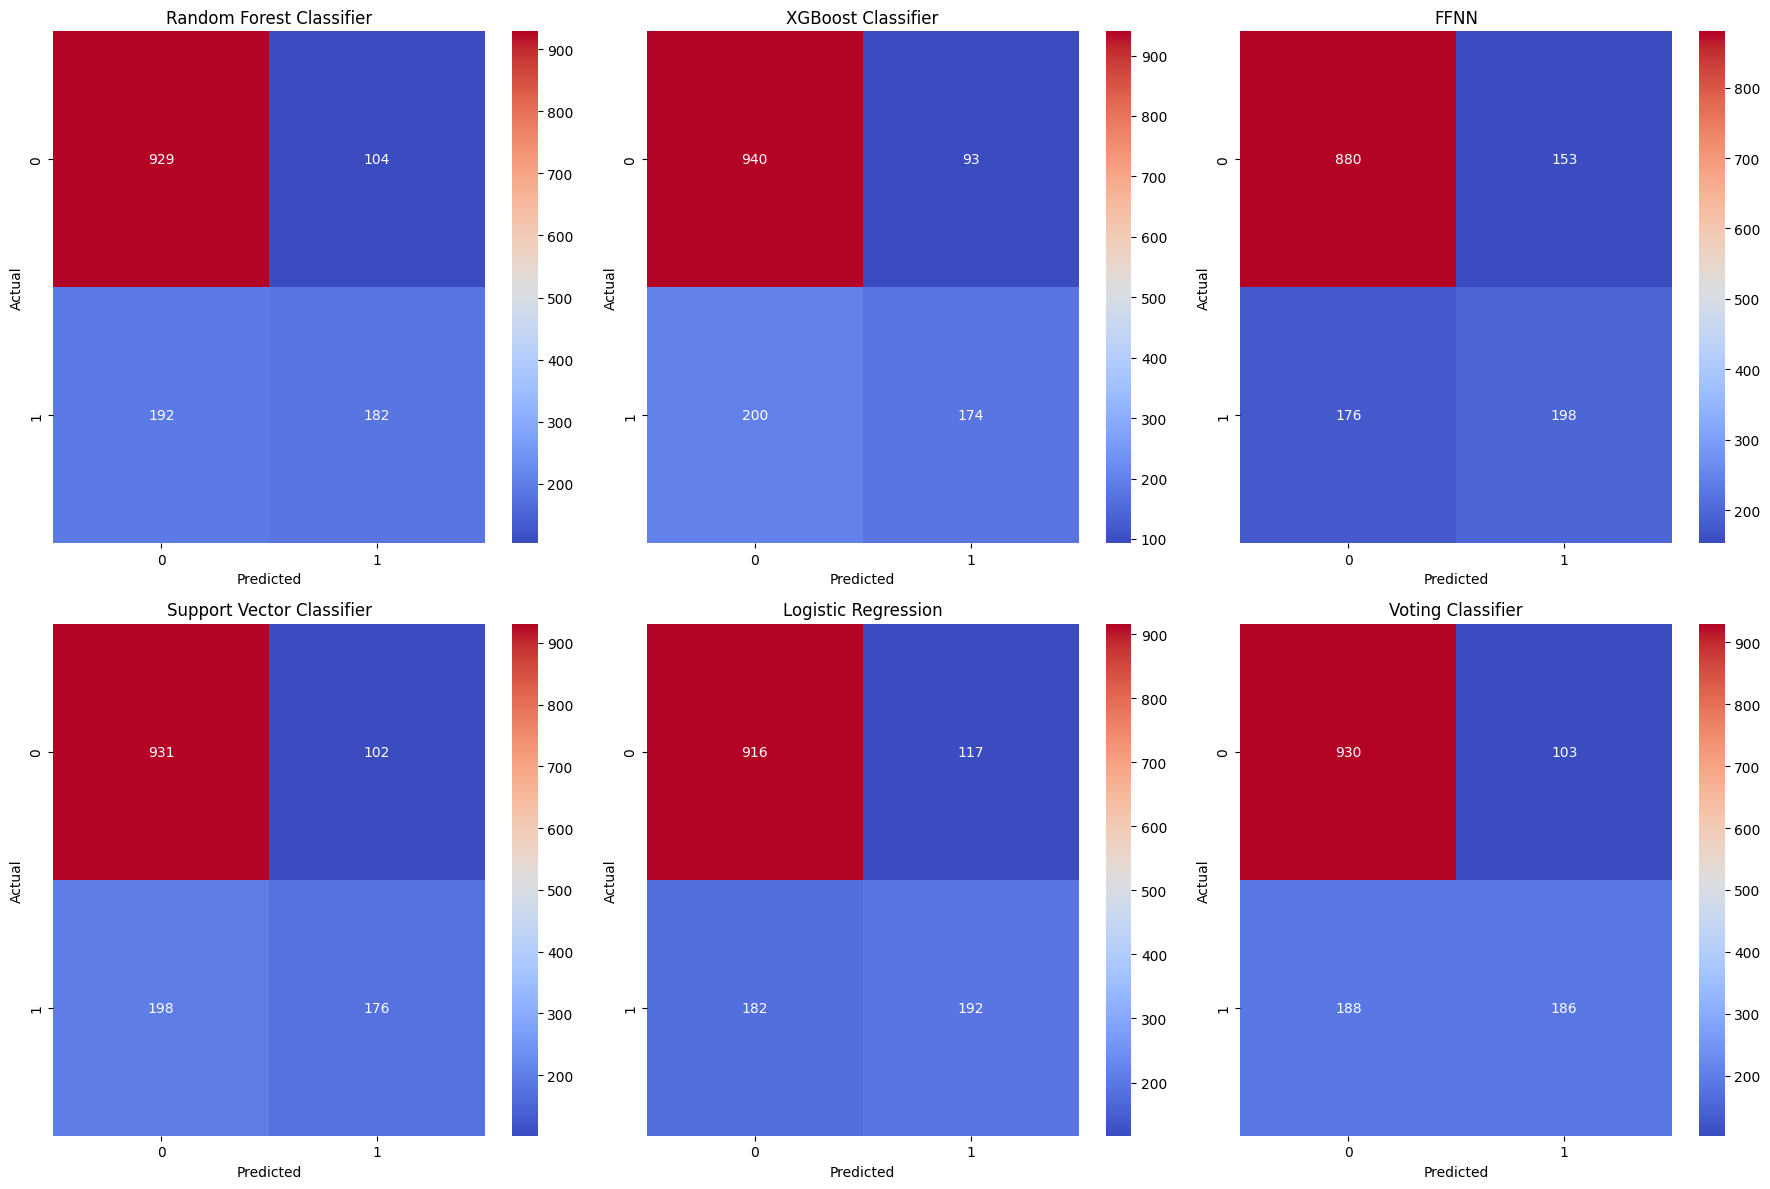

In [10]:
# Compute confusion matrices for each classifier
cm_rfc = confusion_matrix(Y_test, Prfc)
cm_xgb = confusion_matrix(Y_test, Pxgb)
cm_svc = confusion_matrix(Y_test, Psvc)
cm_lr = confusion_matrix(Y_test, Plr)
cm_ffnn = confusion_matrix(Y_test, Pffnn)
cm_voting = confusion_matrix(Y_test, Pvoting)


# Plotting the confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plotting confusion matrix for Random Forest Classifier
sns.heatmap(cm_rfc, annot=True, cmap='coolwarm', fmt='d', ax=axes[0, 0])
axes[0, 0].set_title('Random Forest Classifier')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')

# Plotting confusion matrix for XGBoost Classifier
sns.heatmap(cm_xgb, annot=True, cmap='coolwarm', fmt='d', ax=axes[0, 1])
axes[0, 1].set_title('XGBoost Classifier')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# Plotting confusion matrix for Support Vector Classifier
sns.heatmap(cm_svc, annot=True, cmap='coolwarm', fmt='d', ax=axes[1, 0])
axes[1, 0].set_title('Support Vector Classifier')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# Plotting confusion matrix for Logistic Regression
sns.heatmap(cm_lr, annot=True, cmap='coolwarm', fmt='d', ax=axes[1, 1])
axes[1, 1].set_title('Logistic Regression')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')

# Plotting confusion matrix for FFNN
sns.heatmap(cm_ffnn, annot=True, cmap='coolwarm', fmt='d', ax=axes[0, 2])
axes[0, 2].set_title('FFNN')
axes[0, 2].set_xlabel('Predicted')
axes[0, 2].set_ylabel('Actual')

# Plotting confusion matrix for Voting Classifier
sns.heatmap(cm_voting, annot=True, cmap='coolwarm', fmt='d', ax=axes[1, 2])
axes[1, 2].set_title('Voting Classifier')
axes[1, 2].set_xlabel('Predicted')
axes[1, 2].set_ylabel('Actual')

plt.tight_layout()
plt.show()


Classification Reports:
Random Forest
              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86      1033
         1.0       0.64      0.49      0.55       374

    accuracy                           0.79      1407
   macro avg       0.73      0.69      0.71      1407
weighted avg       0.78      0.79      0.78      1407


XGBoost
              precision    recall  f1-score   support

         0.0       0.82      0.91      0.87      1033
         1.0       0.65      0.47      0.54       374

    accuracy                           0.79      1407
   macro avg       0.74      0.69      0.70      1407
weighted avg       0.78      0.79      0.78      1407


Logistic Regression
              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      1033
         1.0       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weight

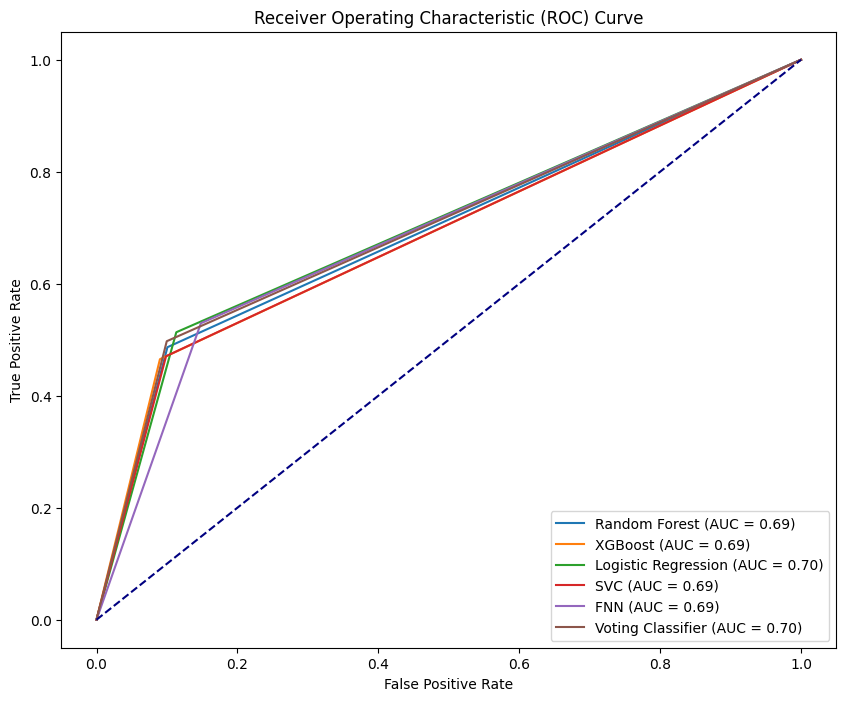

In [13]:
# Generate classification report for each classifier
class_reports = {}
auc_roc_scores = {}
fprs = {}
tprs = {}

class_reports['Random Forest'] = classification_report(Y_test, Prfc)
class_reports['XGBoost'] = classification_report(Y_test, Pxgb)
class_reports['Logistic Regression'] = classification_report(Y_test, Plr)
class_reports['SVC'] = classification_report(Y_test, Psvc)
class_reports['FNN'] = classification_report(Y_test, Pffnn)
class_reports['Voting Classifier'] = classification_report(Y_test, Pvoting)  

# Print classification reports
print("Classification Reports:")
for name, report in class_reports.items():
    print(name)
    print(report)
    print()

# Calculate AUC-ROC for each classifier
auc_roc_scores['Random Forest'] = roc_auc_score(Y_test, Prfc)
auc_roc_scores['XGBoost'] = roc_auc_score(Y_test, Pxgb)
auc_roc_scores['Logistic Regression'] = roc_auc_score(Y_test, Plr)
auc_roc_scores['SVC'] = roc_auc_score(Y_test, Psvc)
auc_roc_scores['FNN'] = roc_auc_score(Y_test, Pffnn)
auc_roc_scores['Voting Classifier'] = roc_auc_score(Y_test, Pvoting)  

# Calculate ROC curve for each classifier
fprs['Random Forest'], tprs['Random Forest'], _ = roc_curve(Y_test, Prfc)
fprs['XGBoost'], tprs['XGBoost'], _ = roc_curve(Y_test, Pxgb)
fprs['Logistic Regression'], tprs['Logistic Regression'], _ = roc_curve(Y_test, Plr)
fprs['SVC'], tprs['SVC'], _ = roc_curve(Y_test, Psvc)
fprs['FNN'], tprs['FNN'], _  = roc_curve(Y_test, Pffnn)
fprs['Voting Classifier'], tprs['Voting Classifier'], _ = roc_curve(Y_test, Pvoting)  

# Plot ROC curve for each classifier
plt.figure(figsize=(10, 8))
for name in fprs:
    plt.plot(fprs[name], tprs[name], label=f'{name} (AUC = {auc_roc_scores[name]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

It can conclude that Ensemble Voting Classifier is the best model for this problem.

In [16]:
# Save the Voting Classifier
with open('weights/churn/churn_analysis.pickle', 'wb') as f:
    pickle.dump(models["Voting Classifier"], f)